## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
print('the number of rows is: {}'.format(df.shape[0]))

the number of rows is: 294478


c. The number of unique users in the dataset.

In [4]:
print('the number of unique users is: {}'.format(df.user_id.nunique()))

the number of unique users is: 290584


d. The proportion of users converted.

In [5]:
print('the proportion of users converted is: {}'.format(df.converted.mean()))

the proportion of users converted is: 0.11965919355605512


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
temp= df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")')
print('the number of times the new_page abd treatment don`t line up is: {}'.format(temp.shape[0]))

the number of times the new_page abd treatment don`t line up is: 3893


f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now create a new dataset that meets the specifications. Store your new dataframe in **df2**.

In [11]:
indexs= df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').index
df2= df.drop(index= indexs, axis= 0)
print(df2.shape[0])

290585


In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [16]:
print('the number of unique users in df2 is: {}'.format(df2.user_id.nunique()))

the number of unique users in df2 is: 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [17]:
df2[df2.user_id.duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [18]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
df2.drop(index=2893, axis=0, inplace=True)
df2.shape[0]

290584

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
print('the probability of an individual converting regardless of the page they receive is: {}'.format(df2.converted.mean()))

the probability of an individual converting regardless of the page they receive is: 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
control_mask= df2.query('group == "control"')
print('the probability of converting to an individual was in control group is: {}'.format(control_mask.converted.mean()))

the probability of converting to an individual was in control group is: 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
treatment_mask= df2.query('group == "treatment"')
print('the probability of converting to an individual was in treatment group is: {}'.format(treatment_mask.converted.mean()))

the probability of converting to an individual was in treatment group is: 0.11880806551510564


d. What is the probability that an individual received the new page?

In [26]:
prob_new_page= df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]
print('the probability that an individual received the new page is: {}'.format(prob_new_page))

the probability that an individual received the new page is: 0.5000619442226688


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**as you can see above, the average probability of converting control group is relatively higher than the average probability of converting treatment group but there is no sufficient evidence to say the old page leads to more conversion.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

   H0 : **$p_{new}$** - **$p_{old}$** <= 0 


   H1 : **$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **convert rate** for $p_{new}$ under the null? 

In [27]:
p_new_null= df2.converted.mean()
p_new_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [28]:
p_old_null= df2.converted.mean()
p_old_null

0.11959708724499628

c. What is $n_{new}$?

In [42]:
n_new= treatment_mask.user_id.count()
n_new

145310

d. What is $n_{old}$?

In [43]:
n_old= control_mask.user_id.count()
n_old

145274

In [44]:
print('p_new - p_old under the null is: {}'.format(p_new_null - p_old_null))

p_new - p_old under the null is: 0.0


**Here as you can see above there is no difference in conversion based on the page which means the conversions for each page are the same, so let us make sampling distribution.**

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [37]:
new_page_converted= treatment_mask.converted.sample(200)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [38]:
old_page_convewrted= control_mask.converted.sample(200)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [39]:
new_page_converted.mean() - old_page_convewrted.mean()

-0.0050000000000000044

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [60]:
p_diffs= []
new_page_sample_mean= np.random.binomial(n_new,df2.converted.mean(),10000) / n_new
old_page_sample_mean= np.random.binomial(n_old,df2.converted.mean(),10000) / n_old
p_diffs= new_page_sample_mean - old_page_sample_mean

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

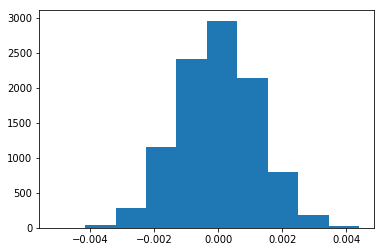

In [61]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [62]:
obs_diff= treatment_mask.converted.mean() - control_mask.converted.mean()
obs_diff

-0.0015782389853555567

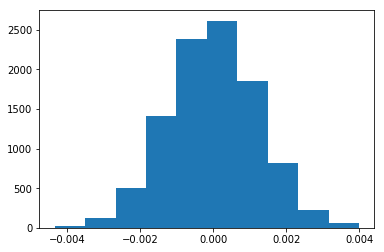

In [63]:
# Simulate distribution under the null hypothesis
null_vals= np.random.normal(0, np.std(p_diffs),len(p_diffs))

# Plot the null distribution
plt.hist(null_vals);

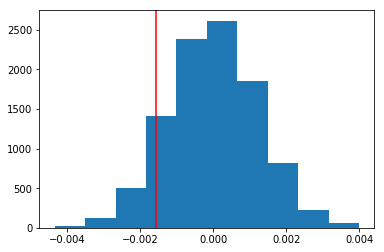

In [64]:
# Plot observed statistic with the null distibution
plt.hist(null_vals);
plt.axvline(x=obs_diff,color='red');

In [65]:
# compute the p-value
(null_vals > obs_diff).mean()

0.9018

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**as you can see above, the value of p-value is 0.90 which is greater than .05 (Type 1 error rate) so we will conclude that we fail to reject null.
(the old page conversion is grater than or equal the conversion of new page)**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [67]:
import statsmodels.api as sm

convert_old = (control_mask.converted== 1).sum()
convert_new = (treatment_mask.converted== 1).sum()
n_old = control_mask.landing_page.count()
n_new = treatment_mask.landing_page.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [72]:
z_statistic, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new,n_old],alternative= 'larger')
print(z_statistic,p_value)

-1.3109241984234394 0.9050583127590245


References used to calac the above test statistic and p-value because the link which you provided is not working:-

    1- https://towardsdatascience.com/demystifying-hypothesis-testing-with-simple-python-examples-4997ad3c5294
    
    2- https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
    
    3- https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**based on the p-value (0.90) which is greater than the alpha (0.05), it is confirmed the result in J and K that we will fail to reject null (the old page conversion is grater than or equal the conversion of new page)**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**this is Classification Problem (Supervised Learning), so we will perform Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [73]:
df2['intercept']= 1
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2[['new','old']]= pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,new,old
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,1


In [74]:
df2.drop(['control','old'],axis=1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment,new
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0


In [75]:
df2['ab_page']= df2['treatment']
df2.drop(['new','treatment'],axis=1,inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [76]:
lr_model= sm.Logit(df2.converted,df2[['intercept','ab_page']])
result= lr_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [77]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Aug 2020   Pseudo R-squ.:               8.077e-06
Time:                        16:24:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**the p-value associated with ab_page is 0.190 which is greater than 0.05, so it suggest there is no statistically significant relationship between ap_page and converted (it is not matter whatever the type of page it is not affect the conversion)**

**P-value is different from the value found in part II because one-sided test was performed in part II as opposed to the two-sided test performed in part III**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**it is a good idea to add more feature into the regression model but you should take care of the multicolinearity between explantory varibles.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [78]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [79]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [80]:
df_new[['US','UK','CA']]= pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [81]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
y, X = dmatrices('converted ~ ab_page + US + CA', df_new, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,5.002944,Intercept
1,1.000006,ab_page
2,1.140206,US
3,1.140205,CA


In [82]:
lr_model_2= sm.Logit(df_new.converted, df_new[['intercept','ab_page','CA','US']])
result_2= lr_model_2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [84]:
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Aug 2020   Pseudo R-squ.:               2.323e-05
Time:                        16:54:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0099      0.013     -0.743      0.457      -0.036       0.016
US            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

**the p-value associated with (ap_page, CA, US) is (0.191, 0.457, 0.074) which are greater than 0.05, so it suggests there are no statistically significant relationship between them and converted (the country does not has impact on conversion)**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [86]:
df_new['CA_ab_page']= df_new.CA * df_new.ab_page
df_new['US_ab_page']= df_new.US * df_new.ab_page
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA,CA_ab_page,US_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [88]:
lr_model_3= sm.Logit(df_new.converted, df_new[['intercept','ab_page','CA','US','CA_ab_page','US_ab_page']])
result_3= lr_model_3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [89]:
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 09 Aug 2020   Pseudo R-squ.:               3.482e-05
Time:                        17:25:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA             0.0057      0.019      0.306      0.760      -0.031       0.043
US            -0.0118      0.040     -0.296      0.767      -0.090       0.066
CA_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
US_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

**the p-value associated with (ap_page, CA, US, CA_ab_page, US_ab_page) is (0.635, 0.760, 0.767, 0.238, 0.168) which are greater than 0.05, so it suggests there are no statistically significant relationship between them and converted (the interaction which we added has no significant effects on conversion)**

In [104]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
duration = df.timestamp.max() - df.timestamp.min()
print('the duration of the experiment is: {}'.format(duration))

the duration of the experiment is: 21 days 23:59:49.081927


<a id='conclusions'></a>
## Conclusions
 

1- this experiment is running for 22 days.

2- the number of users which see the new_page (145310) and old_page(145274) during the experiment is almost fair.

3- the number of users which converted is 34753 and which not converted is 255831.

4- after doing A/B test, we conclude that the old page conversion is equal or greater than the new page conversion.

5- the country, landing page and interaction between them are not statistically significant to predict whether the user converted or not.

6- finally, I suggest the company to keep the old page or run the experiment for a long time.